In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian
from Neural_Network import NLM
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

In [3]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot

    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.2, color='green', label='class 2')


    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    print(n)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
        xx = polynomial_features.fit_transform(xx)

    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5

    i = 0

    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        i += 1

    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')

    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes, forward, weights):
        self.intercept = intercept
        self.slopes = slopes
        self.forward = forward
        self.weights = weights

    def predict(self, x):
        print(x.shape)
        print(self.slopes.shape)
        #y = sigmoid((x.reshape(-1,20)).dot(self.slopes) + self.intercept)
        #y = sigmoid((x).dot(self.slopes) + self.intercept)
        y=self.forward(self.weights, x.T)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

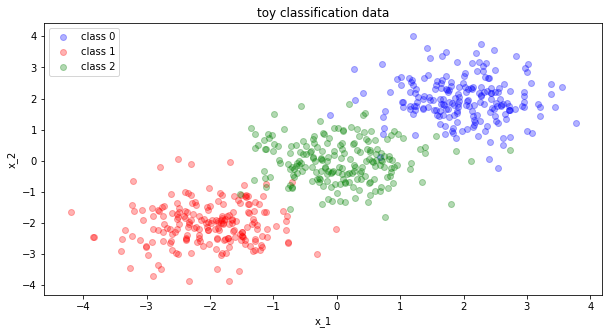

In [4]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params = [params_1, params_2,params_3]
x, y = two_clusters_gaussian(params, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# test BNN
* 3 classes
* output dim =3
* 2000 samples, step size 1e-2m

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn2 = Feedforward(architecture, random=random)

In [6]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn2.fit(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound 11494.36385626232; gradient mag: 718.2510120118507
Iteration 100 lower bound 11378.44832976054; gradient mag: 416.49315509026445
Iteration 200 lower bound 11240.572622624342; gradient mag: 516.7852760443236
Iteration 300 lower bound 11072.851799406002; gradient mag: 530.5755186377783
Iteration 400 lower bound 10895.903813144778; gradient mag: 219.49101550851412
Iteration 500 lower bound 10840.178087986988; gradient mag: 130.32397589932495
Iteration 600 lower bound 10809.956026385495; gradient mag: 89.61032430939132
Iteration 700 lower bound 10794.283673446276; gradient mag: 73.21875391740713
Iteration 800 lower bound 10781.924900349599; gradient mag: 58.126814964959664
Iteration 900 lower bound 10775.131887781225; gradient mag: 45.25616198287525
Iteration 1000 lower bound 10770.289497473146; gradient mag: 36.536587798336285
Iteration 1100 lower bound 10767.436621891831; gradient mag: 28.970968290361682
Iteration 1200 lower bound 10765.555392507697; gradient mag:

In [8]:
print(nn2.forward(nn2.weights,x.T)[0][0][:200],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][200:400],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][400:],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0].sum())

[2.74620329e-07 6.26352719e-07 2.62674204e-07 3.03637848e-06
 2.12027480e-05 1.09938625e-05 2.14226960e-07 3.28823711e-07
 2.15452819e-08 1.00863822e-06 4.43170451e-09 1.28620903e-04
 1.19411585e-08 4.37640440e-07 5.38367716e-07 1.79183874e-08
 3.01577483e-06 1.86814071e-07 2.49726136e-07 9.99104139e-07
 1.23472505e-06 3.64517785e-07 1.55269729e-07 1.24945914e-05
 2.25977689e-07 1.23008534e-05 2.24058008e-06 1.69058758e-05
 1.40081058e-06 1.56351371e-07 4.46702015e-06 2.69753892e-05
 1.58570094e-05 3.01078086e-05 1.09123784e-05 7.76312561e-08
 2.71667820e-06 1.04179030e-04 7.02947035e-06 1.34279471e-06
 6.34944647e-05 6.68797708e-07 4.47322865e-05 4.54163122e-06
 1.69292082e-05 7.66557941e-06 7.87283782e-07 6.48269002e-09
 5.93205436e-07 2.83232493e-05 4.31112464e-06 1.65473480e-06
 5.72428728e-04 1.91156649e-05 2.10486840e-06 3.96464980e-06
 7.04790655e-05 1.05268585e-04 4.69803378e-07 1.74407640e-03
 9.07720185e-06 7.52155609e-07 1.36995779e-06 4.32913601e-06
 2.32402103e-05 7.363352

In [8]:
def softmax(y):
    y=y[0]
    return np.exp(y)/(np.exp(y).sum(1).reshape(3,-1))

A=np.array([np.ones((3,600))])
A.sum(1)

softmax(A).shape

(3, 600)

In [9]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn2.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn2.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, D_bayes)) - (nn2.forward(W, x.T)))**2, axis=2).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)


log_likelihood(nn2.weights)

100 : 0.99 False
200 : 0.975 False
300 : 0.9633333333333334 False
400 : 0.93 False
500 : 0.906 False
600 : 0.9 False
700 : 0.8871428571428571 False
800 : 0.86875 False
900 : 0.86 False
1000 : 0.86 False
1100 : 0.8572727272727273 False
1200 : 0.8666666666666667 False
1300 : 0.8523076923076923 False
1400 : 0.8621428571428571 False
1500 : 0.8546666666666667 False
1600 : 0.856875 False
1700 : 0.8647058823529412 False
1800 : 0.8722222222222222 False
1900 : 0.8752631578947369 False


-2133.2993496196264

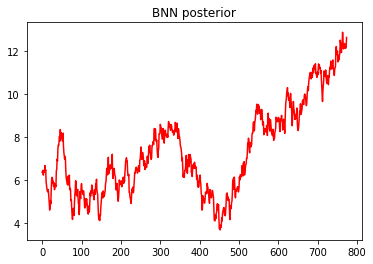

In [10]:
q_=np.asarray(q).T
plt.plot(range(len(q_[0])),q_[0] , color='r')
plt.title('BNN posterior')
plt.show()

120
(14400, 2)
(92,)


ValueError: cannot reshape array of size 43200 into shape (120,120)

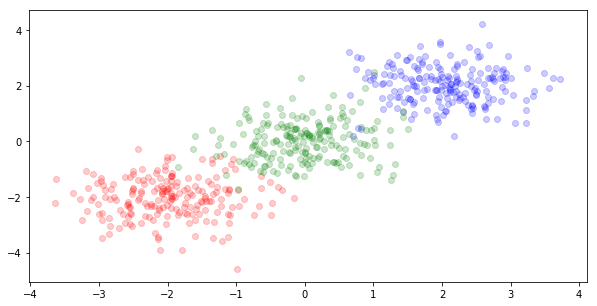

In [27]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
model=Bayesian_logistic_regression(nn2.weights[0][-1],nn2.weights[0][:-1],nn2.forward,nn2.weights)
ax = plot_decision_boundary(x, y, [model], ax, poly_degree=1,  shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

# NLM

In [8]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 2
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [9]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)
nlm.fit_MLE(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound 4309.693916631756; gradient mag: 2414.324413819872
Iteration 100 lower bound 3887.716964553258; gradient mag: 591.107980041309
Iteration 200 lower bound 3707.572870292404; gradient mag: 280.03667203818446
Iteration 300 lower bound 3661.838638485098; gradient mag: 124.77171301330173
Iteration 400 lower bound 3642.5090228205795; gradient mag: 96.99829435138099
Iteration 500 lower bound 3628.3012432985233; gradient mag: 78.42614911442033
Iteration 600 lower bound 3618.1595585353225; gradient mag: 67.0246442891591
Iteration 700 lower bound 3610.1732718991684; gradient mag: 57.539500691043266
Iteration 800 lower bound 3604.315301917342; gradient mag: 44.37174451193441
Iteration 900 lower bound 3600.5628445294315; gradient mag: 37.885323412669585
Iteration 1000 lower bound 3597.780086244659; gradient mag: 33.08287412466491
Iteration 1100 lower bound 3595.5549157040346; gradient mag: 29.168007032431095
Iteration 1200 lower bound 3593.57979203719; gradient mag: 26.75488

Iteration 10400 lower bound 3570.4437325410013; gradient mag: 19.826609952310402
Iteration 10500 lower bound 3570.376457296888; gradient mag: 25.019752998430874
Iteration 10600 lower bound 3570.2766785737754; gradient mag: 23.39770268019521
Iteration 10700 lower bound 3570.182608363428; gradient mag: 16.03416167456433
Iteration 10800 lower bound 3570.0994492472796; gradient mag: 12.552684590778984
Iteration 10900 lower bound 3570.012313823159; gradient mag: 13.914702498535512
Iteration 11000 lower bound 3569.9404479822315; gradient mag: 12.759286766368003
Iteration 11100 lower bound 3569.8651254074607; gradient mag: 15.421217094125947
Iteration 11200 lower bound 3569.7952798898564; gradient mag: 23.867668753429324
Iteration 11300 lower bound 3569.7239663899877; gradient mag: 12.759949147710783
Iteration 11400 lower bound 3569.6574959416853; gradient mag: 23.908764508793553
Iteration 11500 lower bound 3569.595440137868; gradient mag: 14.236775991694316
Iteration 11600 lower bound 3569.5

In [10]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nlm.weights,
       'burn':.1, 
       'thin':2,}

sigmoid_probability=nlm.forward(nlm.weights, x.T)
sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1 - 1e-15)
bce = np.dot(np.log(sigmoid_probability),y.flatten())
bce1 = sum([np.dot(np.log(sigmoid_probability)[:,:,i],y.flatten()[i]) for i in range(len(y.flatten()))])
#-sum([p[i]*log2(q[i]) for i in range(len(p))])
#print(bce,'\n',bce1)


nlm.forward(nlm.weights,x.T)[0][0].reshape(3,-1)


array([[4.22638759e-10, 1.45629476e-16, 2.60030371e-16, 3.41443276e-17,
        4.82658639e-09, 6.16817414e-15, 6.22597674e-21, 2.54131879e-23,
        1.64451717e-22, 3.24953138e-15, 4.00556487e-09, 2.95594257e-16,
        2.96377253e-17, 3.51871647e-13, 5.33405816e-10, 2.16774891e-23,
        8.32930349e-13, 3.72825020e-14, 1.73504282e-15, 4.10331263e-12,
        9.36018120e-11, 5.27666421e-12, 5.27762234e-05, 1.52929643e-27,
        2.54770310e-15, 2.03016008e-11, 2.23836585e-16, 3.85692071e-05,
        3.56386923e-18, 8.75498108e-21, 2.15393888e-19, 7.70582581e-12,
        3.84201537e-19, 1.88326543e-03, 2.10754090e-15, 2.21551096e-17,
        1.46909300e-06, 2.16224685e-17, 1.22361999e-10, 1.83196015e-09,
        2.13399579e-11, 9.09179398e-30, 2.02310267e-10, 4.55968621e-23,
        3.92565015e-13, 6.16421825e-15, 9.78583717e-14, 7.29211182e-16,
        3.38597586e-10, 1.18503963e-13, 2.40003233e-06, 8.17853295e-15,
        1.14485401e-05, 4.57271842e-15, 3.91468649e-05, 2.922291

In [11]:
print(nlm.weights)
nlm.fit_NLM(x.T, y.reshape(1,-1),hmc,params_hmc)

[[ 1.74087131  0.42587314  1.67729327  1.99811694  2.47463283 -0.58930977
   1.05416143  0.90431669  0.47238115  0.52723469  0.16814733  1.48586846
  -0.38154113 -0.72158443  1.44376221  0.39909544  1.09861517  0.14461847
   0.77708026 -2.27509298 -1.59571261  0.5676787  -1.49509858  1.61893685
   1.29702133 -1.7365766   0.70652175 -5.41370609  1.72341167  1.05390829
  -0.14847237  0.22728931  0.09421647 -1.52960243 -0.62093225  0.73052956
   1.51159176 -0.05654452  0.21092279 -1.00354851 -2.74468938 -2.72864742
  -2.57642315  2.05080362 -3.14669932 -4.57723462 -3.83008431  3.61334732
  -1.17291963 -0.53143127 -4.44423377 -3.77669025  3.56412442 -1.17352479
  -0.53234272 -2.7412599  -3.85048679  3.63576339 -1.18444063 -0.54619564
  -0.67246027 -0.35955384 -0.81314604]]


ValueError: shapes (1,63) and (1,5,600) not aligned: 63 (dim 1) != 5 (dim 1)